# Explore correlations between metabolite profiles and QTL LOD scores

Can correlations be used as a way to group observations to increase power?

In [1]:
options(repr.plot.width = 6)
options(repr.plot.height = 5)

In [78]:
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);

## Load metabolite data

Use log2 abundance. Compute pearson correlation between all pairs of metabolites across all timepoints and strains

In [8]:
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)
endo_small = endometabolite %>% filter(time_format=="absolute", value.log2 > 0) %>% select(strain,metabolite,replicate,time,value.log2) 
m = unique(endo_small$metabolite)
endo_corr = do.call(rbind,lapply(m,function(i){
    do.call(cbind,lapply(m,function(j){
        d1 = endo_small %>% filter(metabolite == i)
        d2 = endo_small %>% filter(metabolite == j)
        d = merge(d1,d2,by=c("strain","time","replicate"))
        cor(d$value.log2.x,d$value.log2.y,use = "pairwise")
    }))
}))
rownames(endo_corr) = m
colnames(endo_corr) = m

## Load QTL profiles

Use log2 abundance. Compute pearson correlation between all pairs of metabolites across all timepoints and strains

In [10]:
devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/mQTL_explorer/global.R");

SHA-1 hash of file is c7b1ec0096632e3a4863bcff8deaf6b8e431a905


[1] 0


SHA-1 hash of file is 850a084e6053540af1afec4793e71109862a40d6


[1] 0


In [40]:
# remove try-errors
mQTLs_funqtl_2014 = mQTLs_funqtl_2014[!sapply(mQTLs_funqtl_2014,function(i)class(i)=="try-error")]
cor_m = do.call(rbind, lapply(seq(1:length(mQTLs_funqtl_2014)),function(i){
    sapply(seq(1:length(mQTLs_funqtl_2014)),function(j){
            #print(paste(i,j))
            cor(mQTLs_funqtl_2014[[i]]$qtls_alt[,"slod"], mQTLs_funqtl_2014[[j]]$qtls_alt[,"slod"])
        })
}))
rownames(cor_m) = names(mQTLs_funqtl_2014)
colnames(cor_m) = names(mQTLs_funqtl_2014)

## Load Stitch

In [50]:
load(file.path("/g/steinmetz/brooks/genphen/resources","genphen_stitch.rda"))

In [71]:
stitch_corr = do.call(rbind, lapply(unique(genphen_stitch$alias), function(i){
    sapply(unique(genphen_stitch$alias), function(j){
        # calculate jaccard
        d1 = filter(genphen_stitch,alias==i)
        d2 = filter(genphen_stitch,alias==j)
        # should it be weighted?
        return(length(intersect(d1$protein,d2$protein))/length(union(d1$protein,d2$protein)))
    })
}))
rownames(stitch_corr) = unique(genphen_stitch$alias)
colnames(stitch_corr) = unique(genphen_stitch$alias)

In [82]:
cg = intersect(intersect(rownames(cor_m),rownames(endo_corr)),rownames(stitch_corr))

## Plot correlations

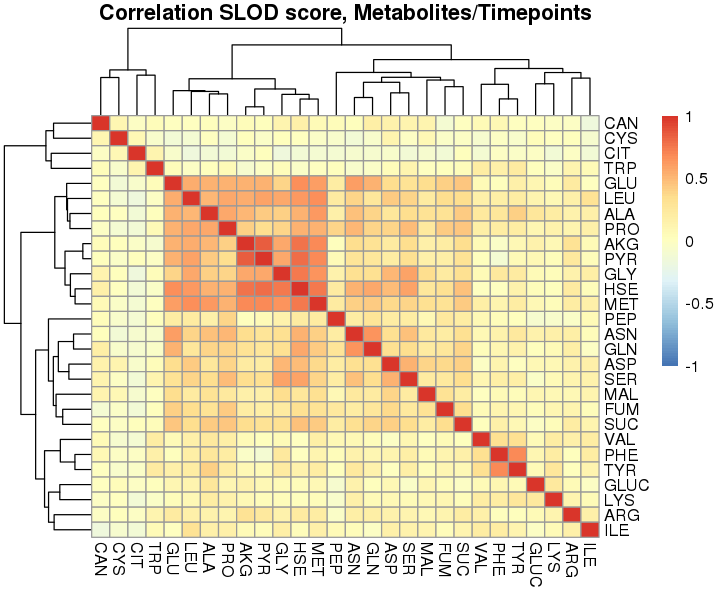

In [86]:
co = pheatmap(cor_m[cg,cg],breaks=seq(-1, 1, length.out = 100), 
         main = "Correlation SLOD score, Metabolites/Timepoints", cluster_rows = T, cluster_cols = T)

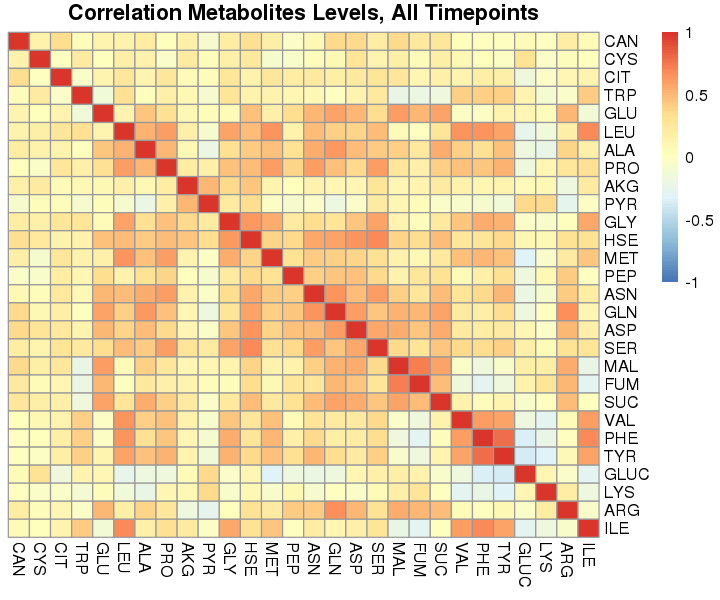

In [87]:
rowo = co$tree_row$labels[co$tree_row$order]
colo = co$tree_col$labels[co$tree_col$order]
pheatmap(endo_corr[rowo,colo],breaks=seq(-1,1,length.out=100),cluster_rows = F,cluster_cols = F,
             main = "Correlation Metabolites Levels, All Timepoints")

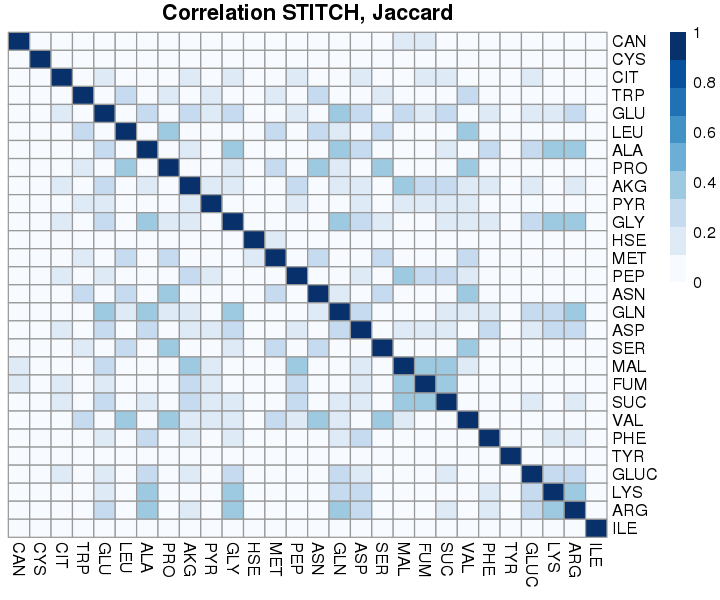

In [88]:
pheatmap(stitch_corr[rowo,colo],breaks=seq(0, 1, length.out = 10), 
         main = "Correlation STITCH, Jaccard", cluster_rows = F, cluster_cols = F, color = brewer.pal(9, "Blues"))